## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

## Hyperparameters

In [2]:
timesteps = 10
hidden_size = 64
epochs = 100
learning_rate = 0.0001
seed = 42

In [3]:
np.random.seed(seed)

## Load, plot, and analyze data

In [4]:
def load_temperature_data():
    data = pd.read_excel('Temperature.xlsx', header=None)
    return data.iloc[:, 0].values

In [5]:
def analyze_data(data, filename_prefix='data_analysis'):
    data_series = pd.Series(data)
    print("Descriptive statistics of data:")
    print(data_series.describe())

    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Temperature Data')
    plt.title('Time Series of Temperature Data')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    data_series.hist(bins=30)
    plt.title('Histogram of Temperature Data Distribution')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    plt.close()

In [6]:
def plot_data(data, train_data, test_data, predictions=None):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Full Data', alpha=0.5)
    plt.plot(range(len(train_data)), train_data, label='Training Data', color='blue')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data,
             label='Test Data', color='orange')
    if predictions is not None:
        print(f"Plotting predictions shape: {predictions.shape}")  # دیباگ
        if predictions.ndim == 1:
            plt.plot(range(len(train_data), len(train_data) + len(predictions)),
                     predictions, label='LSTM Predictions', color='red')
        else:
            plt.plot(range(len(train_data), len(train_data) + len(predictions)),
                     predictions[:, -1], label='LSTM Predictions', color='red')
    plt.title('Distribution and Prediction of Temperature Data')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

In [7]:
def plot_regression(y_true, y_pred, title, filename):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()
    plt.close()

## Preprocess data

In [8]:
def normalize_data(data):
    min_val, max_val = np.min(data), np.max(data)
    normalized = (data - min_val) / (max_val - min_val)
    return normalized, min_val, max_val

In [9]:
def denormalize_data(normalized, min_val, max_val):
    normalized = np.array(normalized)
    return normalized * (max_val - min_val) + min_val

In [10]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps - timesteps + 2):
        X.append(data[i:i + timesteps])
        y.append(data[i + 2:i + timesteps + 2])
    return np.array(X), np.array(y)

## Activation functions

In [11]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

In [12]:
def sigmoid_derivative(output):
    return output * (1 - output)

In [13]:
def tanh(x):
    return np.tanh(np.clip(x, -500, 500))

In [14]:
def tanh_derivative(output):
    return 1 - output ** 2

## Loss functions

In [15]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [16]:
def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

In [17]:
def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

## Model

In [18]:
class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        limit = np.sqrt(6 / (hidden_size + input_size))
        self.Wf = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.Wi = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.Wo = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.Wc = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.bf = np.zeros(hidden_size)
        self.bi = np.zeros(hidden_size)
        self.bo = np.zeros(hidden_size)
        self.bc = np.zeros(hidden_size)
        self.Wy = np.random.uniform(-limit, limit, (1, hidden_size))
        self.by = np.zeros(1)

    def forward(self, x, h_prev, c_prev):
        self.x, self.h_prev, self.c_prev = x, h_prev, c_prev
        self.combined = np.hstack((h_prev, x))
        self.f = sigmoid(np.dot(self.Wf, self.combined) + self.bf)
        self.i = sigmoid(np.dot(self.Wi, self.combined) + self.bi)
        self.o = sigmoid(np.dot(self.Wo, self.combined) + self.bo)
        self.c_hat = tanh(np.dot(self.Wc, self.combined) + self.bc)
        self.c = self.f * c_prev + self.i * self.c_hat
        self.h = self.o * tanh(self.c)
        self.y_pred = np.dot(self.Wy, self.h) + self.by
        return self.y_pred, self.h, self.c

    def backward(self, dL_dy, dh_next, dc_next, learning_rate):
        dL_dy = np.array(dL_dy).reshape(-1)
        dy_dh = self.Wy
        dh = np.dot(dy_dh.T, dL_dy) + dh_next
        dc = dh * self.o * tanh_derivative(tanh(self.c)) + dc_next

        df = dc * self.c_prev * sigmoid_derivative(self.f)
        di = dc * self.c_hat * sigmoid_derivative(self.i)
        do = dh * tanh(self.c) * sigmoid_derivative(self.o)
        dc_hat = dc * self.i * tanh_derivative(self.c_hat)

        dWf = np.dot(df.reshape(-1, 1), self.combined.reshape(1, -1))
        dWi = np.dot(di.reshape(-1, 1), self.combined.reshape(1, -1))
        dWo = np.dot(do.reshape(-1, 1), self.combined.reshape(1, -1))
        dWc = np.dot(dc_hat.reshape(-1, 1), self.combined.reshape(1, -1))

        dbf = df
        dbi = di
        dbo = do
        dbc = dc_hat

        dWy = np.dot(dL_dy.reshape(-1, 1), self.h.reshape(1, -1))
        dby = dL_dy

        clip_value = 1.0
        dWf = np.clip(dWf, -clip_value, clip_value)
        dWi = np.clip(dWi, -clip_value, clip_value)
        dWo = np.clip(dWo, -clip_value, clip_value)
        dWc = np.clip(dWc, -clip_value, clip_value)
        dbf = np.clip(dbf, -clip_value, clip_value)
        dbi = np.clip(dbi, -clip_value, clip_value)
        dbo = np.clip(dbo, -clip_value, clip_value)
        dbc = np.clip(dbc, -clip_value, clip_value)
        dWy = np.clip(dWy, -clip_value, clip_value)
        dby = np.clip(dby, -clip_value, clip_value)

        self.Wf -= learning_rate * dWf
        self.Wi -= learning_rate * dWi
        self.Wo -= learning_rate * dWo
        self.Wc -= learning_rate * dWc
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc
        self.Wy -= learning_rate * dWy
        self.by -= learning_rate * dby.reshape(-1)

        dcombined = np.dot(self.Wf.T, df) + np.dot(self.Wi.T, di) + \
                    np.dot(self.Wo.T, do) + np.dot(self.Wc.T, dc_hat)
        dh_prev = dcombined[:self.hidden_size]
        dc_prev = dc * self.f

        return dh_prev, dc_prev

## Train model

In [19]:
def train_model(model, X_train, y_train, epochs, learning_rate):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X_train)):
            x_seq = X_train[i]
            y_true_seq = y_train[i]
            h_t = np.zeros(model.hidden_size)
            c_t = np.zeros(model.hidden_size)
            states = []
            y_preds = []

            for t in range(len(x_seq)):
                x_t = x_seq[t].reshape(-1)
                y_pred, h_t, c_t = model.forward(x_t, h_t, c_t)
                y_preds.append(y_pred[0])
                states.append((model.x, model.h_prev, model.c_prev, model.combined,
                              model.f, model.i, model.o, model.c_hat, model.c, model.h))

            y_preds = np.array(y_preds)
            loss = mse_loss(y_true_seq, y_preds)
            epoch_loss += loss

            dh_next = np.zeros(model.hidden_size)
            dc_next = np.zeros(model.hidden_size)
            for t in reversed(range(len(x_seq))):
                model.x, model.h_prev, model.c_prev, model.combined, \
                model.f, model.i, model.o, model.c_hat, model.c, model.h = states[t]
                dL_dy = mse_loss_derivative(y_true_seq[t], y_preds[t])
                dh_prev, dc_prev = model.backward(dL_dy, dh_next, dc_next, learning_rate)
                dh_next, dc_next = dh_prev, dc_prev

        avg_loss = epoch_loss / len(X_train)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")
    return losses

## Predict

In [20]:
def predict(model, X, timesteps):
    predictions = []
    for i in range(len(X)):
        x_seq = X[i]
        h_t = np.zeros(model.hidden_size)
        c_t = np.zeros(model.hidden_size)
        y_preds = []
        for t in range(timesteps):
            x_t = x_seq[t].reshape(-1)
            y_pred, h_t, c_t = model.forward(x_t, h_t, c_t)
            y_preds.append(y_pred[0])
        predictions.append(y_preds)
    predictions = np.array(predictions)
    print(f"Predictions shape: {predictions.shape}")  # دیباگ
    return predictions

## Main

### Load & analyze data

In [21]:
data = load_temperature_data()

Analyzing raw data...
Descriptive statistics of data:
count    336.000000
mean      19.902679
std        8.975760
min       -1.800000
25%       12.000000
50%       20.400000
75%       28.000000
max       37.800000
dtype: float64


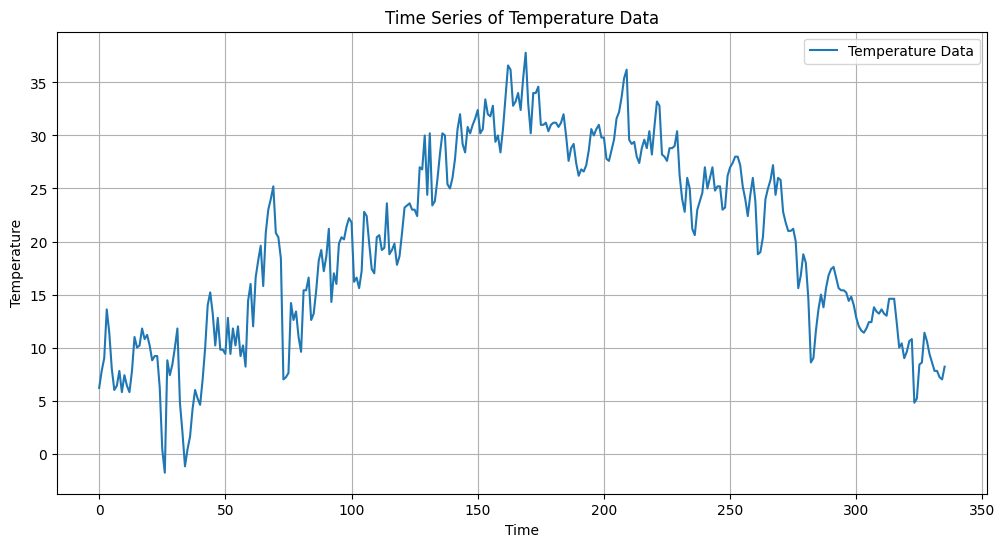

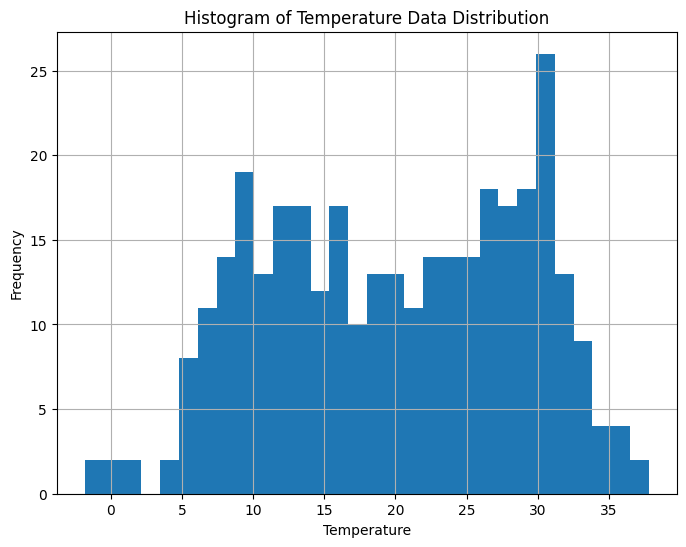

In [22]:
print("Analyzing raw data...")
analyze_data(data)

### Preprocess data

In [23]:
data_normalized, min_val, max_val = normalize_data(data)

In [24]:
X, y = create_sequences(data_normalized, timesteps)

In [25]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (318, 10), y shape: (318, 10)


### Train/Test Split

In [26]:
train_size = int(0.8 * len(X))

In [27]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (254, 10), y_train shape: (254, 10)
X_test shape: (64, 10), y_test shape: (64, 10)


### Visualize raw data

In [29]:
train_data = denormalize_data(X_train[:, 0], min_val, max_val)
test_data = denormalize_data(X_test[:, 0], min_val, max_val)

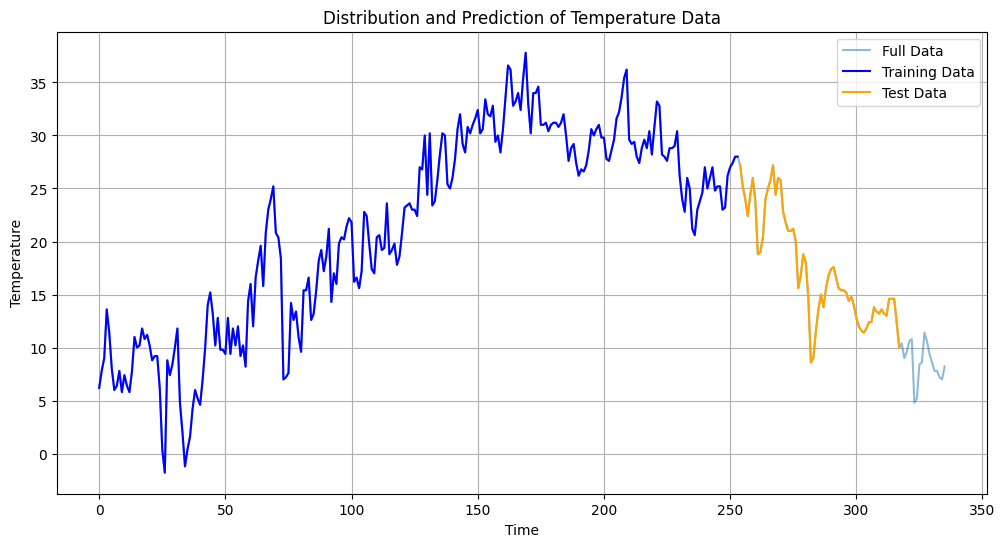

In [30]:
plot_data(data, train_data, test_data)

### Model Creation

In [31]:
model = LSTMCell(input_size=1, hidden_size=hidden_size)

### Train model

In [32]:
print("Training LSTM...")
losses = train_model(model, X_train, y_train, epochs, learning_rate)

Training LSTM...
Epoch 1/100, Loss: 0.202754
Epoch 2/100, Loss: 0.053796
Epoch 3/100, Loss: 0.041391
Epoch 4/100, Loss: 0.040732
Epoch 5/100, Loss: 0.040048
Epoch 6/100, Loss: 0.039047
Epoch 7/100, Loss: 0.037955
Epoch 8/100, Loss: 0.036865
Epoch 9/100, Loss: 0.035805
Epoch 10/100, Loss: 0.034783
Epoch 11/100, Loss: 0.033798
Epoch 12/100, Loss: 0.032848
Epoch 13/100, Loss: 0.031933
Epoch 14/100, Loss: 0.031050
Epoch 15/100, Loss: 0.030198
Epoch 16/100, Loss: 0.029375
Epoch 17/100, Loss: 0.028581
Epoch 18/100, Loss: 0.027815
Epoch 19/100, Loss: 0.027074
Epoch 20/100, Loss: 0.026359
Epoch 21/100, Loss: 0.025668
Epoch 22/100, Loss: 0.025001
Epoch 23/100, Loss: 0.024358
Epoch 24/100, Loss: 0.023737
Epoch 25/100, Loss: 0.023138
Epoch 26/100, Loss: 0.022561
Epoch 27/100, Loss: 0.022005
Epoch 28/100, Loss: 0.021470
Epoch 29/100, Loss: 0.020955
Epoch 30/100, Loss: 0.020459
Epoch 31/100, Loss: 0.019983
Epoch 32/100, Loss: 0.019526
Epoch 33/100, Loss: 0.019088
Epoch 34/100, Loss: 0.018667
Epoch 

## Result

### Get Prediction

In [33]:
train_predictions_normalized = predict(model, X_train, timesteps)
test_predictions_normalized = predict(model, X_test, timesteps)

Predictions shape: (254, 10)
Predictions shape: (64, 10)


In [34]:
print(f"train_predictions shape before denorm: {train_predictions_normalized.shape}")
print(f"test_predictions shape before denorm: {test_predictions_normalized.shape}")

train_predictions shape before denorm: (254, 10)
test_predictions shape before denorm: (64, 10)


### Denormalize predictions

In [35]:
train_predictions = denormalize_data(train_predictions_normalized, min_val, max_val)
test_predictions = denormalize_data(test_predictions_normalized, min_val, max_val)

In [36]:
print(f"train_predictions shape after denorm: {train_predictions.shape}")
print(f"test_predictions shape after denorm: {test_predictions.shape}")

train_predictions shape after denorm: (254, 10)
test_predictions shape after denorm: (64, 10)


In [37]:
y_train_denorm = denormalize_data(y_train, min_val, max_val)
y_test_denorm = denormalize_data(y_test, min_val, max_val)

### Evaluate model

In [38]:
train_mse = mse_loss(y_train_denorm, train_predictions)
test_mse = mse_loss(y_test_denorm, test_predictions)
train_mae = mae_loss(y_train_denorm, train_predictions)
test_mae = mae_loss(y_test_denorm, test_predictions)

In [39]:
print(f"Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

Train MSE: 17.0097, Train MAE: 3.1180
Test MSE: 12.7951, Test MAE: 2.8586


### Visualize

Plotting predictions shape: (64, 10)


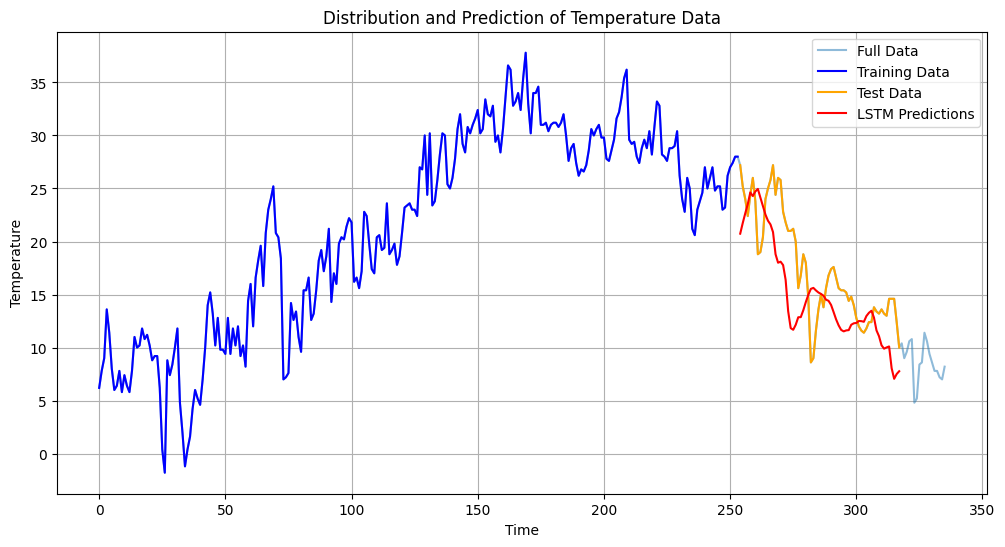

In [40]:
plot_data(data, train_data, test_data, test_predictions)

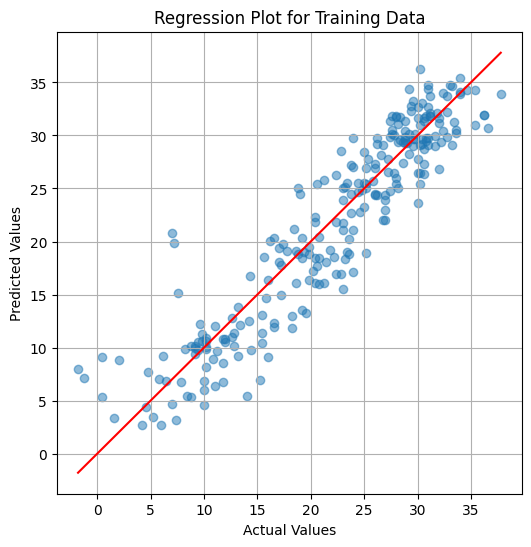

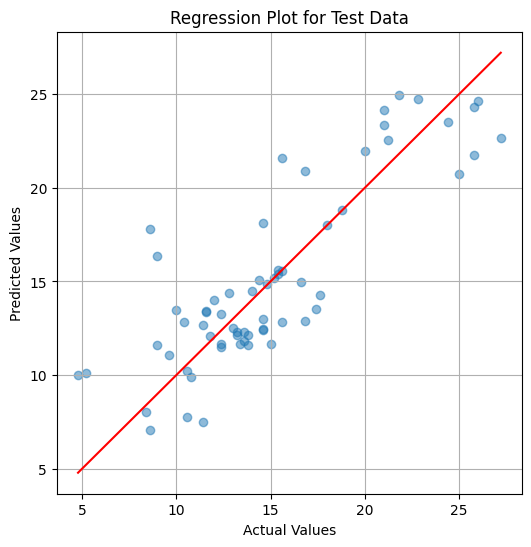

In [41]:
plot_regression(y_train_denorm[:, -1], train_predictions[:, -1],
                "Regression Plot for Training Data", "regression_train.png")
plot_regression(y_test_denorm[:, -1], test_predictions[:, -1],
                "Regression Plot for Test Data", "regression_test.png")

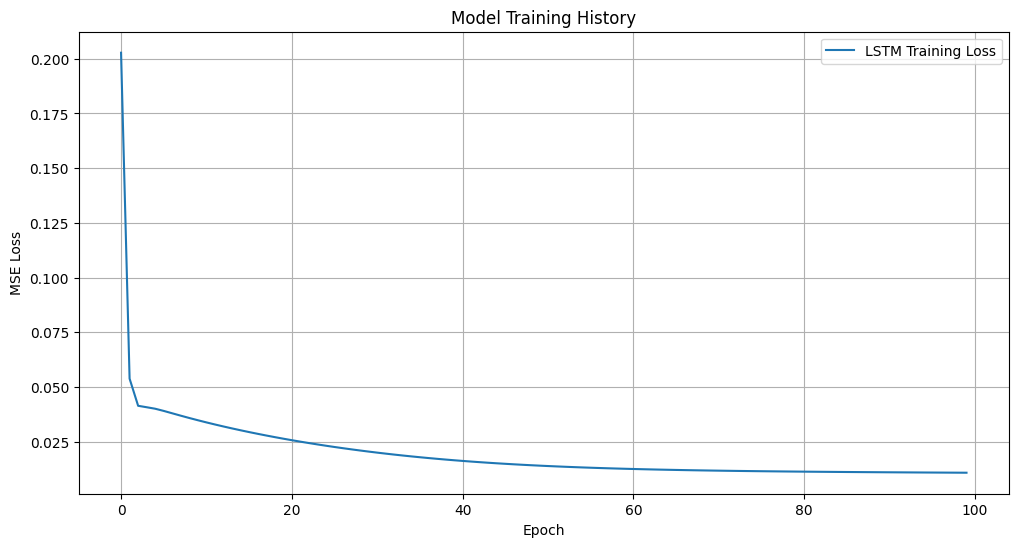

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(losses, label='LSTM Training Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.close()